In [7]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('training_data_filled_2.09.csv')

## Бинарная классификация

### Разбиваем данные на классы по порогам

In [3]:
df['reduction_0'] = df.penalty_reduction_ratio == 0
df['reduction_up_to_20'] = df.penalty_reduction_ratio <= 0.2
df['reduction_up_to_40'] = df.penalty_reduction_ratio <= 0.4
df['reduction_up_to_50'] = df.penalty_reduction_ratio <= 0.5
df['reduction_up_to_80'] = df.penalty_reduction_ratio <= 0.8

In [4]:
total = 0
for col in ['reduction_0', 'reduction_up_to_20', 'reduction_up_to_40', 'reduction_up_to_50',
            'reduction_up_to_80']:
    print(col, ': posittive --', sum(df[col]), ', negative --', len(df[col]) - sum(df[col]))
    total += sum(df[col])

reduction_0 : posittive -- 23 , negative -- 101
reduction_up_to_20 : posittive -- 28 , negative -- 96
reduction_up_to_40 : posittive -- 36 , negative -- 88
reduction_up_to_50 : posittive -- 57 , negative -- 67
reduction_up_to_80 : posittive -- 94 , negative -- 30


### Добавляем категориальные признаки

In [5]:
def transform_into_onehot(column_name, df):
    encoding_dict = {
        c: i for (i, c) in enumerate(df[column_name].unique())
    }
    encoded = np.zeros((len(df), len(encoding_dict)))
    for i, val in enumerate(df[column_name]):
        one_place = encoding_dict[val]
        encoded[i][one_place] = 1
    return encoded

In [8]:
encoded_type_of_contract = transform_into_onehot('type_of_contract', df)
encoded_appeal_courts = transform_into_onehot('appeal_courts', df)
encoded_judge_gender = transform_into_onehot('judge_gender', df)
encoded_year = transform_into_onehot('year', df)

In [13]:
features = df[[
    'claimed_penalty', 'contract_penalty_percentage', 'prepayment', 'contract_price', 'delay',
    'debt_amount'
]].values

In [15]:
features = np.hstack([features, encoded_type_of_contract, encoded_appeal_courts, encoded_judge_gender, encoded_year])

### Разделяем на train и test

In [17]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(
    features, df.reduction_0, test_size=0.3, random_state=42)

In [21]:
sum(y_train), sum(y_test)

(14, 9)

### Обучаем модель

#### Случайный лес (RandomForestClassifier)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [30]:
# обучение
dt_clf = RandomForestClassifier()
dt_clf.fit(X_train, y_train)

RandomForestClassifier()

In [31]:
# качество на тесте
pred = dt_clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.81      1.00      0.89        29
        True       1.00      0.22      0.36         9

    accuracy                           0.82        38
   macro avg       0.90      0.61      0.63        38
weighted avg       0.85      0.82      0.77        38



In [33]:
# вероятность класса 0 (снижение -- 0%)
probas = dt_clf.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'is_0_class': y_test, 'probability_of_0_class': probas})
results[results['is_0_class']]

,is_0_class,probability_of_0_class
36,True,0.41
53,True,0.15
56,True,0.59
27,True,0.82
44,True,0.35
19,True,0.12
47,True,0.15
45,True,0.11
22,True,0.37


#### LogisticRegression

In [35]:
from sklearn.linear_model import LogisticRegression

In [70]:
clf = LogisticRegression(class_weight={True: 5, False: 1})
clf.fit(X_train, y_train)

LogisticRegression(class_weight={False: 1, True: 5})

In [71]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.94      0.52      0.67        29
        True       0.36      0.89      0.52         9

    accuracy                           0.61        38
   macro avg       0.65      0.70      0.59        38
weighted avg       0.80      0.61      0.63        38



In [72]:
# вероятность класса 0 (снижение -- 0%)
probas = clf.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'is_0_class': y_test, 'probability_of_0_class': probas})
results[results['is_0_class']]

,is_0_class,probability_of_0_class
36,True,0.534279
53,True,0.602395
56,True,0.999928
27,True,0.523462
44,True,0.515715
19,True,0.155289
47,True,0.736110
45,True,0.507583
22,True,0.742281


### KNN

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [66]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.78      0.97      0.86        29
        True       0.50      0.11      0.18         9

    accuracy                           0.76        38
   macro avg       0.64      0.54      0.52        38
weighted avg       0.71      0.76      0.70        38



In [181]:
probas = clf.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'is_0_class': y_test, 'probability_of_0_class': probas, 'вероятность снижения (%)': 1 - probas})
results[results['is_0_class']]

## Разделитель -- 20%

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    features, df.reduction_up_to_20, test_size=0.3, random_state=42)

### KNN

In [74]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

In [78]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.75      0.96      0.84        28
        True       0.50      0.10      0.17        10

    accuracy                           0.74        38
   macro avg       0.62      0.53      0.51        38
weighted avg       0.68      0.74      0.67        38



In [79]:
probas = dt_clf.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'is_<20_class': y_test, 'probability_of_<20_class': probas})
results[results['is_<20_class']]

,is_<20_class,probability_of_<20_class
36,True,0.41
53,True,0.15
56,True,0.59
27,True,0.82
44,True,0.35
19,True,0.12
47,True,0.15
45,True,0.11
73,True,0.11
22,True,0.37


### LogReg

In [80]:
clf = LogisticRegression(class_weight={True: 4, False: 1})
clf.fit(X_train, y_train)

LogisticRegression(class_weight={False: 1, True: 4})

In [81]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.88      0.79      0.83        28
        True       0.54      0.70      0.61        10

    accuracy                           0.76        38
   macro avg       0.71      0.74      0.72        38
weighted avg       0.79      0.76      0.77        38



In [84]:
probas = dt_clf.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'is_<20_class': y_test, 'probability_of_<20_class': probas})
results[results['is_<20_class']]

,is_<20_class,probability_of_<20_class
36,True,0.41
53,True,0.15
56,True,0.59
27,True,0.82
44,True,0.35
19,True,0.12
47,True,0.15
45,True,0.11
73,True,0.11
22,True,0.37


### RandomForest

In [85]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [88]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.80      1.00      0.89        28
        True       1.00      0.30      0.46        10

    accuracy                           0.82        38
   macro avg       0.90      0.65      0.68        38
weighted avg       0.85      0.82      0.78        38



In [89]:
probas = dt_clf.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'is_<20_class': y_test, 'probability_of_<20_class': probas})
results[results['is_<20_class']]

,is_<20_class,probability_of_<20_class
36,True,0.41
53,True,0.15
56,True,0.59
27,True,0.82
44,True,0.35
19,True,0.12
47,True,0.15
45,True,0.11
73,True,0.11
22,True,0.37


## Разделитель -- 40%

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    features, df.reduction_up_to_40, test_size=0.3, random_state=42)

### KNN

In [113]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [114]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.69      0.92      0.79        26
        True       0.33      0.08      0.13        12

    accuracy                           0.66        38
   macro avg       0.51      0.50      0.46        38
weighted avg       0.57      0.66      0.58        38



In [115]:
probas = clf.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'is_<40_class': y_test, 'probability_of_<40_class': probas})
results[results['is_<40_class']]

,is_<40_class,probability_of_<40_class
36,True,0.2
53,True,0.2
56,True,0.4
122,True,0.2
27,True,0.6
44,True,0.0
19,True,0.2
47,True,0.2
12,True,0.0
45,True,0.4


### LogReg

In [116]:
clf = LogisticRegression(class_weight={True: 3, False: 1})
clf.fit(X_train, y_train)

LogisticRegression(class_weight={False: 1, True: 3})

In [117]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.79      0.42      0.55        26
        True       0.38      0.75      0.50        12

    accuracy                           0.53        38
   macro avg       0.58      0.59      0.53        38
weighted avg       0.66      0.53      0.53        38



In [118]:
probas = clf.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'is_<40_class': y_test, 'probability_of_<40_class': probas})
results[results['is_<40_class']]

,is_<40_class,probability_of_<40_class
36,True,0.526387
53,True,0.526641
56,True,0.997385
122,True,0.007602
27,True,0.574605
44,True,0.541131
19,True,0.302273
47,True,0.603409
12,True,0.000824
45,True,0.517439


## Разделитель -- 50%

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    features, df.reduction_up_to_50, test_size=0.3, random_state=42)

### KNN

In [121]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [124]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.50      0.78      0.61        18
        True       0.60      0.30      0.40        20

    accuracy                           0.53        38
   macro avg       0.55      0.54      0.50        38
weighted avg       0.55      0.53      0.50        38



In [126]:
probas = clf.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'is_<50_class': y_test, 'probability_of_<50_class': probas})
results[results['is_<50_class']]

,is_<50_class,probability_of_<50_class
36,True,0.4
53,True,0.4
56,True,0.6
122,True,0.2
4,True,0.2
27,True,0.8
44,True,0.6
95,True,0.2
19,True,0.4
77,True,0.2


### LogReg

In [127]:
clf = LogisticRegression(class_weight={True: 3, False: 1})
clf.fit(X_train, y_train)

LogisticRegression(class_weight={False: 1, True: 3})

In [128]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.36      0.22      0.28        18
        True       0.48      0.65      0.55        20

    accuracy                           0.45        38
   macro avg       0.42      0.44      0.41        38
weighted avg       0.43      0.45      0.42        38



In [129]:
probas = clf.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'is_<50_class': y_test, 'probability_of_<50_class': probas})
results[results['is_<50_class']]

,is_<50_class,probability_of_<50_class
36,True,0.583353
53,True,0.726887
56,True,1.000000
122,True,0.000042
4,True,0.210903
27,True,0.750848
44,True,0.649115
95,True,0.407697
19,True,0.190162
77,True,0.605533


## Разделитель -- 80%

In [130]:
X_train, X_test, y_train, y_test = train_test_split(
    features, df.reduction_up_to_80, test_size=0.3, random_state=42)

### KNN

In [131]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [132]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.25      0.14      0.18         7
        True       0.82      0.90      0.86        31

    accuracy                           0.76        38
   macro avg       0.54      0.52      0.52        38
weighted avg       0.72      0.76      0.74        38



In [134]:
probas = clf.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'is_<80_class': y_test, 'probability_of_<80_class': probas})
results[results['is_<80_class']]

,is_<80_class,probability_of_<80_class
18,True,0.8
42,True,0.6
36,True,1.0
76,True,0.6
53,True,0.8
56,True,0.8
122,True,0.4
121,True,0.8
4,True,0.8
27,True,1.0


### LogReg

In [141]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [142]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.20      0.29      0.24         7
        True       0.82      0.74      0.78        31

    accuracy                           0.66        38
   macro avg       0.51      0.51      0.51        38
weighted avg       0.71      0.66      0.68        38



In [143]:
probas = clf.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'is_<80_class': y_test, 'probability_of_<80_class': probas})
results[results['is_<80_class']]

,is_<80_class,probability_of_<80_class
18,True,0.289596
42,True,0.161978
36,True,0.561344
76,True,0.712681
53,True,0.894271
56,True,1.000000
122,True,0.001263
121,True,0.655010
4,True,0.312535
27,True,0.668070


## Мультиклассовая классификация

In [144]:
def get_label(ratio):
    if ratio == 0:
        return 'reduction_0'
    
    if ratio <= 0.4:
        return 'reduction_1_to_40'
    
    if ratio <= 0.75:
        return 'reduction_41_to_75'
    
    return 'reduction_76_to_100'

In [145]:
df['range'] = df.penalty_reduction_ratio.apply(get_label)

In [146]:
df.range.value_counts()

reduction_41_to_75     52
reduction_76_to_100    36
reduction_0            23
reduction_1_to_40      13
Name: range, dtype: int64

In [147]:
X_train, X_test, y_train, y_test = train_test_split(
    features, df.range, test_size=0.3, random_state=11)

In [148]:
dt_clf = RandomForestClassifier()
dt_clf.fit(X_train, y_train)

RandomForestClassifier()

In [149]:
pred = dt_clf.predict(X_test)
print(classification_report(y_test, pred))

                     precision    recall  f1-score   support

        reduction_0       0.50      0.33      0.40         9
  reduction_1_to_40       0.00      0.00      0.00         5
 reduction_41_to_75       0.35      0.64      0.45        11
reduction_76_to_100       0.80      0.62      0.70        13

           accuracy                           0.47        38
          macro avg       0.41      0.40      0.39        38
       weighted avg       0.49      0.47      0.46        38



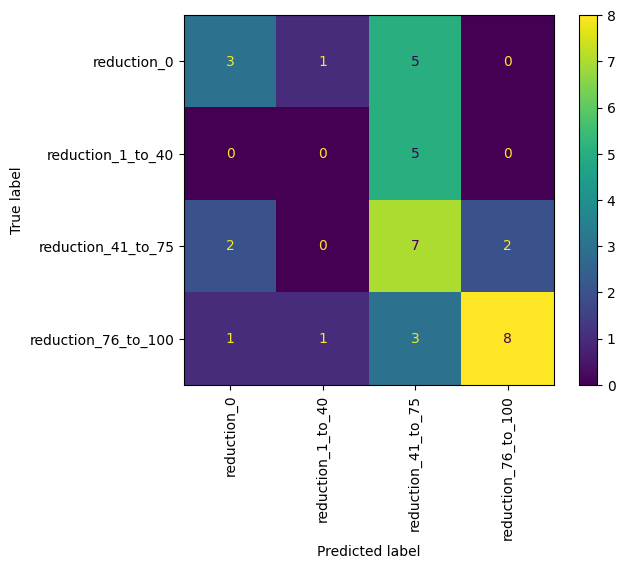

In [150]:
cm = confusion_matrix(y_test, pred, labels=dt_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dt_clf.classes_)
disp.plot(xticks_rotation='vertical')

In [151]:
probas = dt_clf.predict_proba(X_test)

In [152]:
results_df = pd.DataFrame({
    'label': y_test,
    'model_predicted': pred,
    'probability_of_0_class': probas[:, 0],
    'reduction_1_to_40': probas[:, 1],
    'reduction_41_to_75': probas[:, 2],
    'reduction_76_to_100': probas[:, 3],
})

In [153]:
results_df[results_df.label == 'reduction_41_to_75']

,label,model_predicted,probability_of_0_class,reduction_1_to_40,reduction_41_to_75,reduction_76_to_100
77,reduction_41_to_75,reduction_41_to_75,0.10,0.05,0.68,0.17
16,reduction_41_to_75,reduction_76_to_100,0.01,0.02,0.41,0.56
97,reduction_41_to_75,reduction_41_to_75,0.10,0.09,0.75,0.06
113,reduction_41_to_75,reduction_41_to_75,0.13,0.11,0.55,0.21
83,reduction_41_to_75,reduction_41_to_75,0.06,0.06,0.67,0.21
35,reduction_41_to_75,reduction_0,0.39,0.13,0.28,0.20
65,reduction_41_to_75,reduction_41_to_75,0.15,0.03,0.62,0.20
15,reduction_41_to_75,reduction_76_to_100,0.10,0.05,0.33,0.52
86,reduction_41_to_75,reduction_41_to_75,0.02,0.04,0.68,0.26
28,reduction_41_to_75,reduction_0,0.47,0.04,0.40,0.09


In [68]:
from sklearn.linear_model import LogisticRegression

In [155]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/Users/ktulhu/.pyenv/versions/3.9.15/envs/ve/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [156]:
pred = log_reg.predict(X_test)
print(classification_report(y_test, pred))

                     precision    recall  f1-score   support

        reduction_0       0.00      0.00      0.00         9
  reduction_1_to_40       0.09      0.20      0.13         5
 reduction_41_to_75       0.29      0.55      0.37        11
reduction_76_to_100       0.67      0.31      0.42        13

           accuracy                           0.29        38
          macro avg       0.26      0.26      0.23        38
       weighted avg       0.32      0.29      0.27        38



/Users/ktulhu/.pyenv/versions/3.9.15/envs/ve/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ktulhu/.pyenv/versions/3.9.15/envs/ve/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ktulhu/.pyenv/versions/3.9.15/envs/ve/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

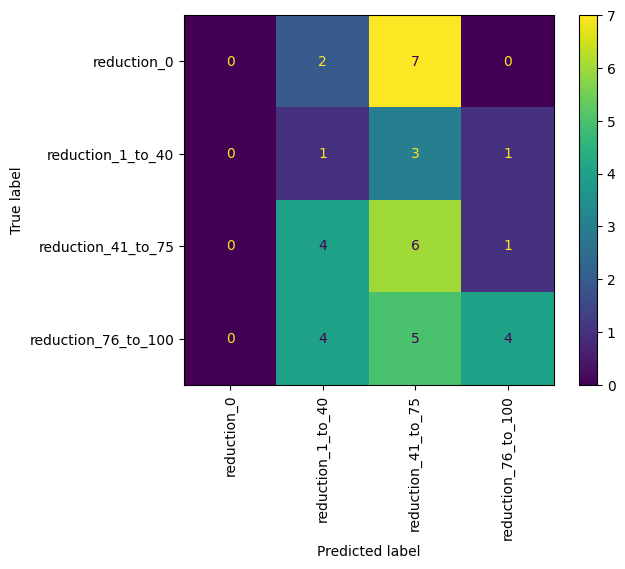

In [157]:
cm = confusion_matrix(y_test, pred, labels=log_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_reg.classes_)
disp.plot(xticks_rotation='vertical')

In [159]:
from sklearn.tree import DecisionTreeClassifier

In [160]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [161]:
pred = clf.predict(X_test)

In [162]:
print(classification_report(y_test, pred))

                     precision    recall  f1-score   support

        reduction_0       0.38      0.33      0.35         9
  reduction_1_to_40       0.00      0.00      0.00         5
 reduction_41_to_75       0.40      0.55      0.46        11
reduction_76_to_100       0.69      0.69      0.69        13

           accuracy                           0.47        38
          macro avg       0.37      0.39      0.38        38
       weighted avg       0.44      0.47      0.45        38



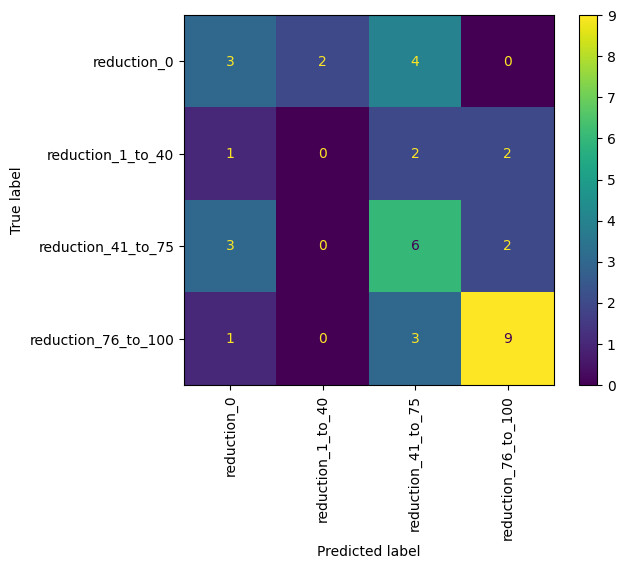

In [163]:
cm = confusion_matrix(y_test, pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot(xticks_rotation='vertical')